In [2]:
#include google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from tensorflow.keras import Input, Model
#from tensorflow.keras.layers import Dense, Dropout, Embedding
#import tensorflow.keras.backend as K
#import tensorflow.keras as keras
from sklearn import preprocessing

import random


In [0]:
# define paths
output_path = '/content/drive/My Drive/Fax/Master Theses/data-inspection'
data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'


In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:

#MAXLIFE = 120
MAXLIFE = 125
def kink_RUL(cycle_list, max_cycle):
    '''
    Piecewise linear function with zero gradient and unit gradient

            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    knee_point = max_cycle - MAXLIFE
    if knee_point <= 0:
      knee_point = 1
      
    kink_RUL = []
    stable_life = MAXLIFE
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - (stable_life / (max_cycle - knee_point))
            kink_RUL.append(tmp)

    return kink_RUL


def compute_rul_of_one_id(FD00X_of_one_id, max_cycle_rul=None):
    '''
    Enter the data of an engine_id of train_FD001 and output the corresponding RUL (remaining life) of these data.
    type is list
    '''

    cycle_list = FD00X_of_one_id['cycle'].tolist()
    if max_cycle_rul is None:
        max_cycle = max(cycle_list)  # Failure cycle
    else:
        max_cycle = max(cycle_list) + max_cycle_rul
        # print(max(cycle_list), max_cycle_rul)

    # return kink_RUL(cycle_list,max_cycle)
    return kink_RUL(cycle_list, max_cycle)


def compute_rul_of_one_file(FD00X, id='engine_id', RUL_FD00X=None):
    '''
    Input train_FD001, output a list
    '''
    rul = []
    # In the loop train, each id value of the 'engine_id' column
    if RUL_FD00X is None:
        for _id in set(FD00X[id]):
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id]))
        return rul
    else:
        rul = []
        for _id in set(FD00X[id]):
            # print("#### id ####", int(RUL_FD00X.iloc[_id - 1]))
            true_rul.append(int(RUL_FD00X.iloc[_id - 1]))
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id], int(RUL_FD00X.iloc[_id - 1])))
        return rul


In [0]:

rul=[]

for id in train_df['id'].unique():
  rul.extend(compute_rul_of_one_id (train_df[train_df['id']== id]))

In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
#rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
#rul.columns = ['id', 'max']
#train_df = train_df.merge(rul, on=['id'], how='left')
#train_df['RUL'] = train_df['max'] - train_df['cycle']
#train_df.drop('max', axis=1, inplace=True)
train_df['RUL']= rul

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [8]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [9]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

train_x = train_df[sequence_cols].values.astype(np.float32)
print(train_x.shape)

(20631, 25)


In [10]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,125.0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,125.0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,125.0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,125.0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,125.0,0.01108


In [11]:
xxxx = train_df[sequence_cols].columns
xxxx

Index(['setting1', 'setting2', 'setting3', 'cycle_norm', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21'],
      dtype='object')

In [0]:
# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]

def display_data(df, engine_id, col_names, rul=None):
    
    engine_data = df[df['id'] == engine_id]
    samples = engine_data.shape[0]
    x = np.arange(samples)
    
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = n // nrows
    
    fig = plt.figure(figsize=(20, n))
    
    print("Engine: {}, Samples: {}, Features: {}".format( engine_id, samples, n))
    
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        y = engine_data[m].values
        ax.plot(x, y)
        
        if rul:
            ax.axvline(x=rul, color='r')
    
    plt.tight_layout()
    plt.show()

In [0]:
def display_multiple(df, engines, col_names):
    
    engine_data = []
    
    for i in engines:
        engine_id = i+1
        engine = train_df[train_df['id'] == engine_id]
        engine_data.append(engine)
        
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = n // nrows
    
    fig = plt.figure(figsize=(20, n))
        
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.legend(engines, loc='upper left')
        ax.set_title(m)
        for i in range(len(engine_data)):
            e = engine_data[i]
            x = np.arange(e.shape[0])
            y = e[m].values
            ax.plot(x, y)
    
    plt.legend(engines, loc='upper left')
    plt.tight_layout()
    plt.show()

Engine: 1, Samples: 192, Features: 3


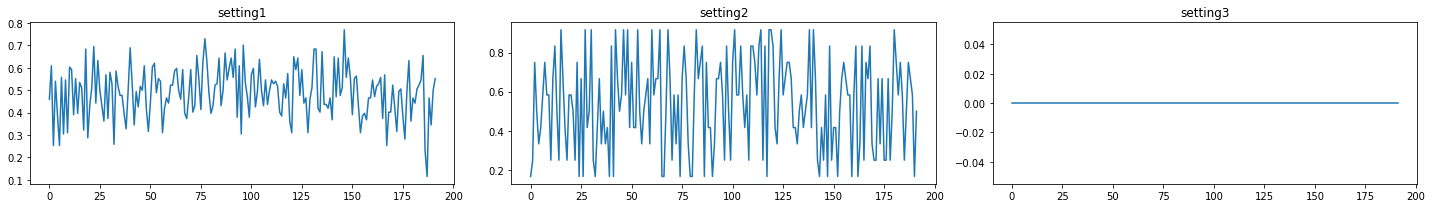

In [0]:
display_data( train_df, 1, setting_cols)

Engine: 20, Samples: 184, Features: 21


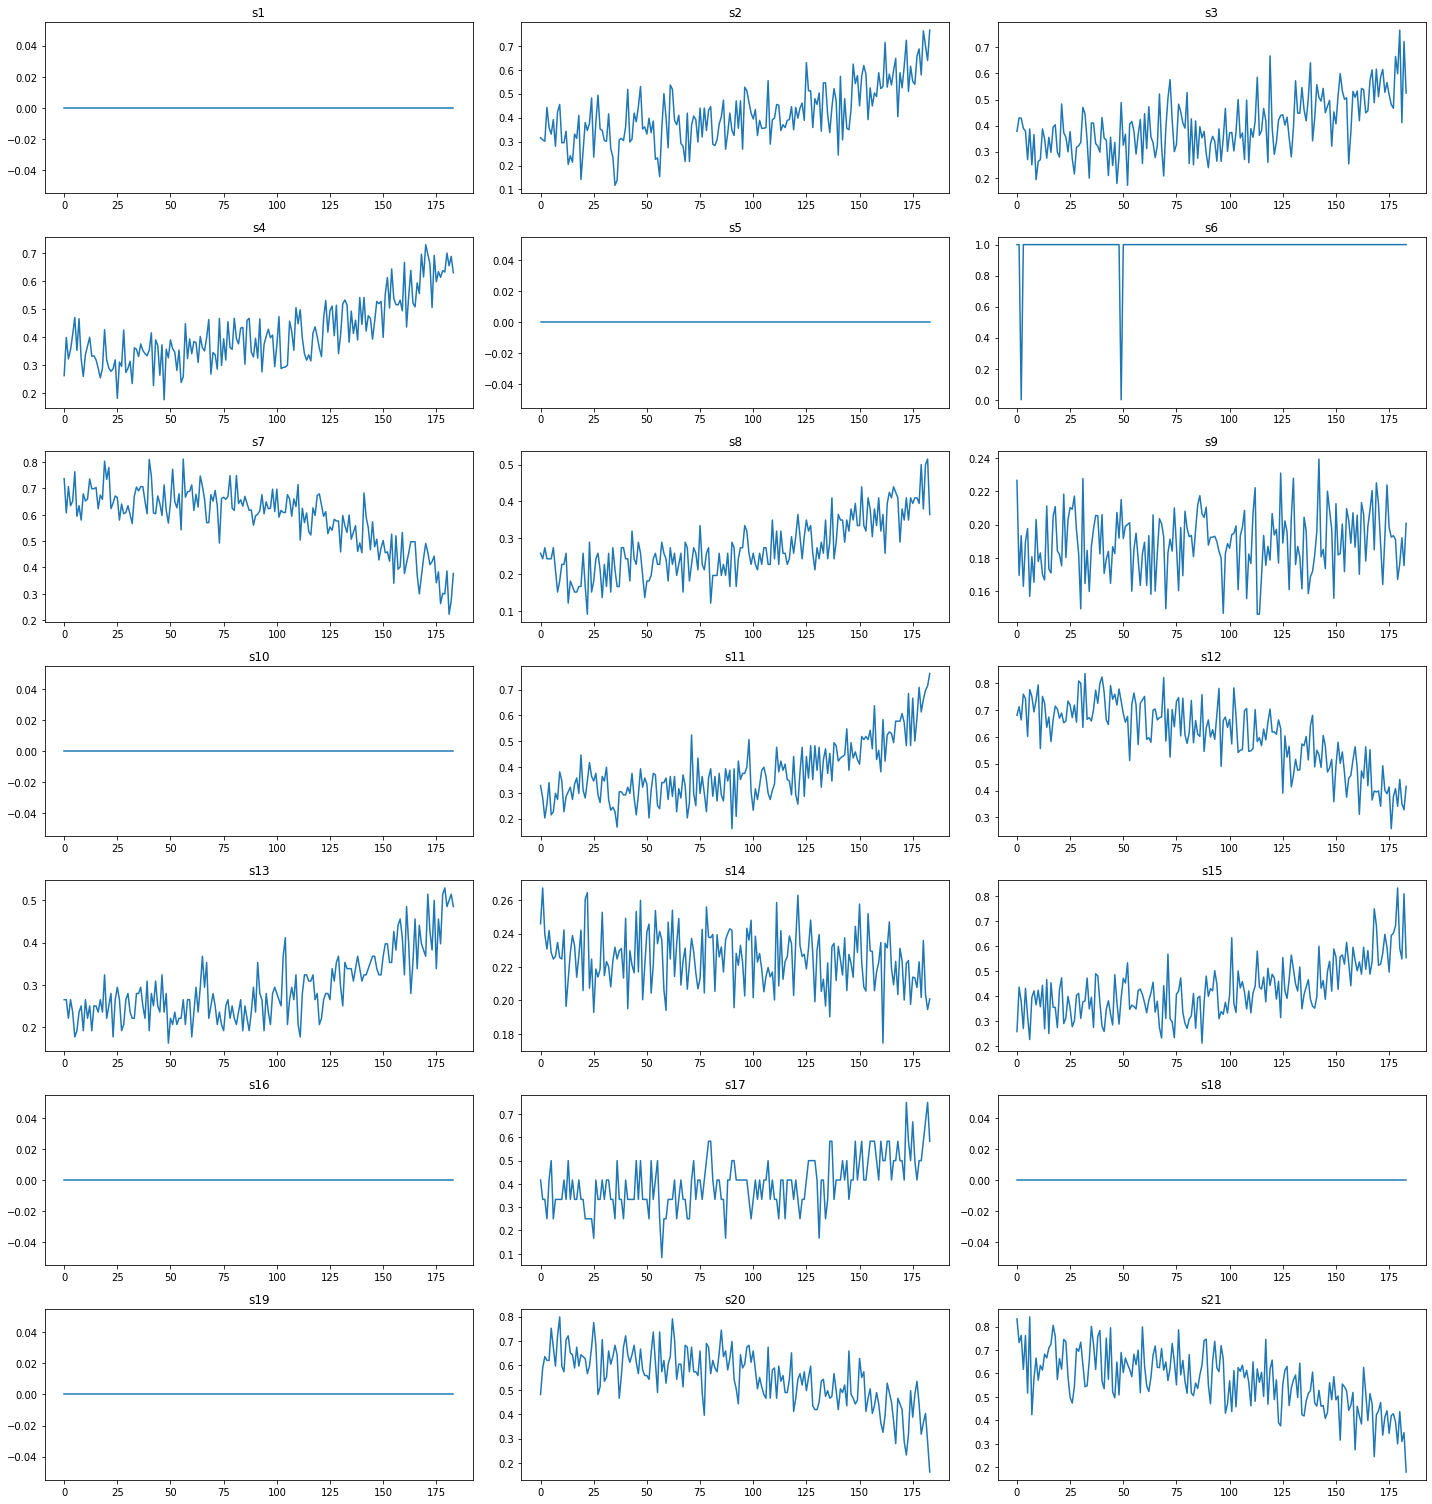

In [0]:
display_data( test_df, 20, sensor_cols)

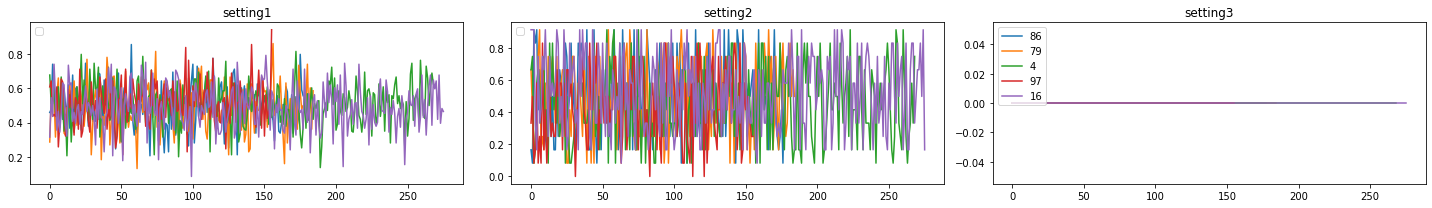

In [0]:

# Compare 10 random engines
engine_ids = [86,79, 4, 97, 16]
#num_engines = train_df.groupby(['id']).count().shape[0]
#engine_ids = random.sample(range(1,num_engines), 2)
display_multiple( train_df, engine_ids, setting_cols)

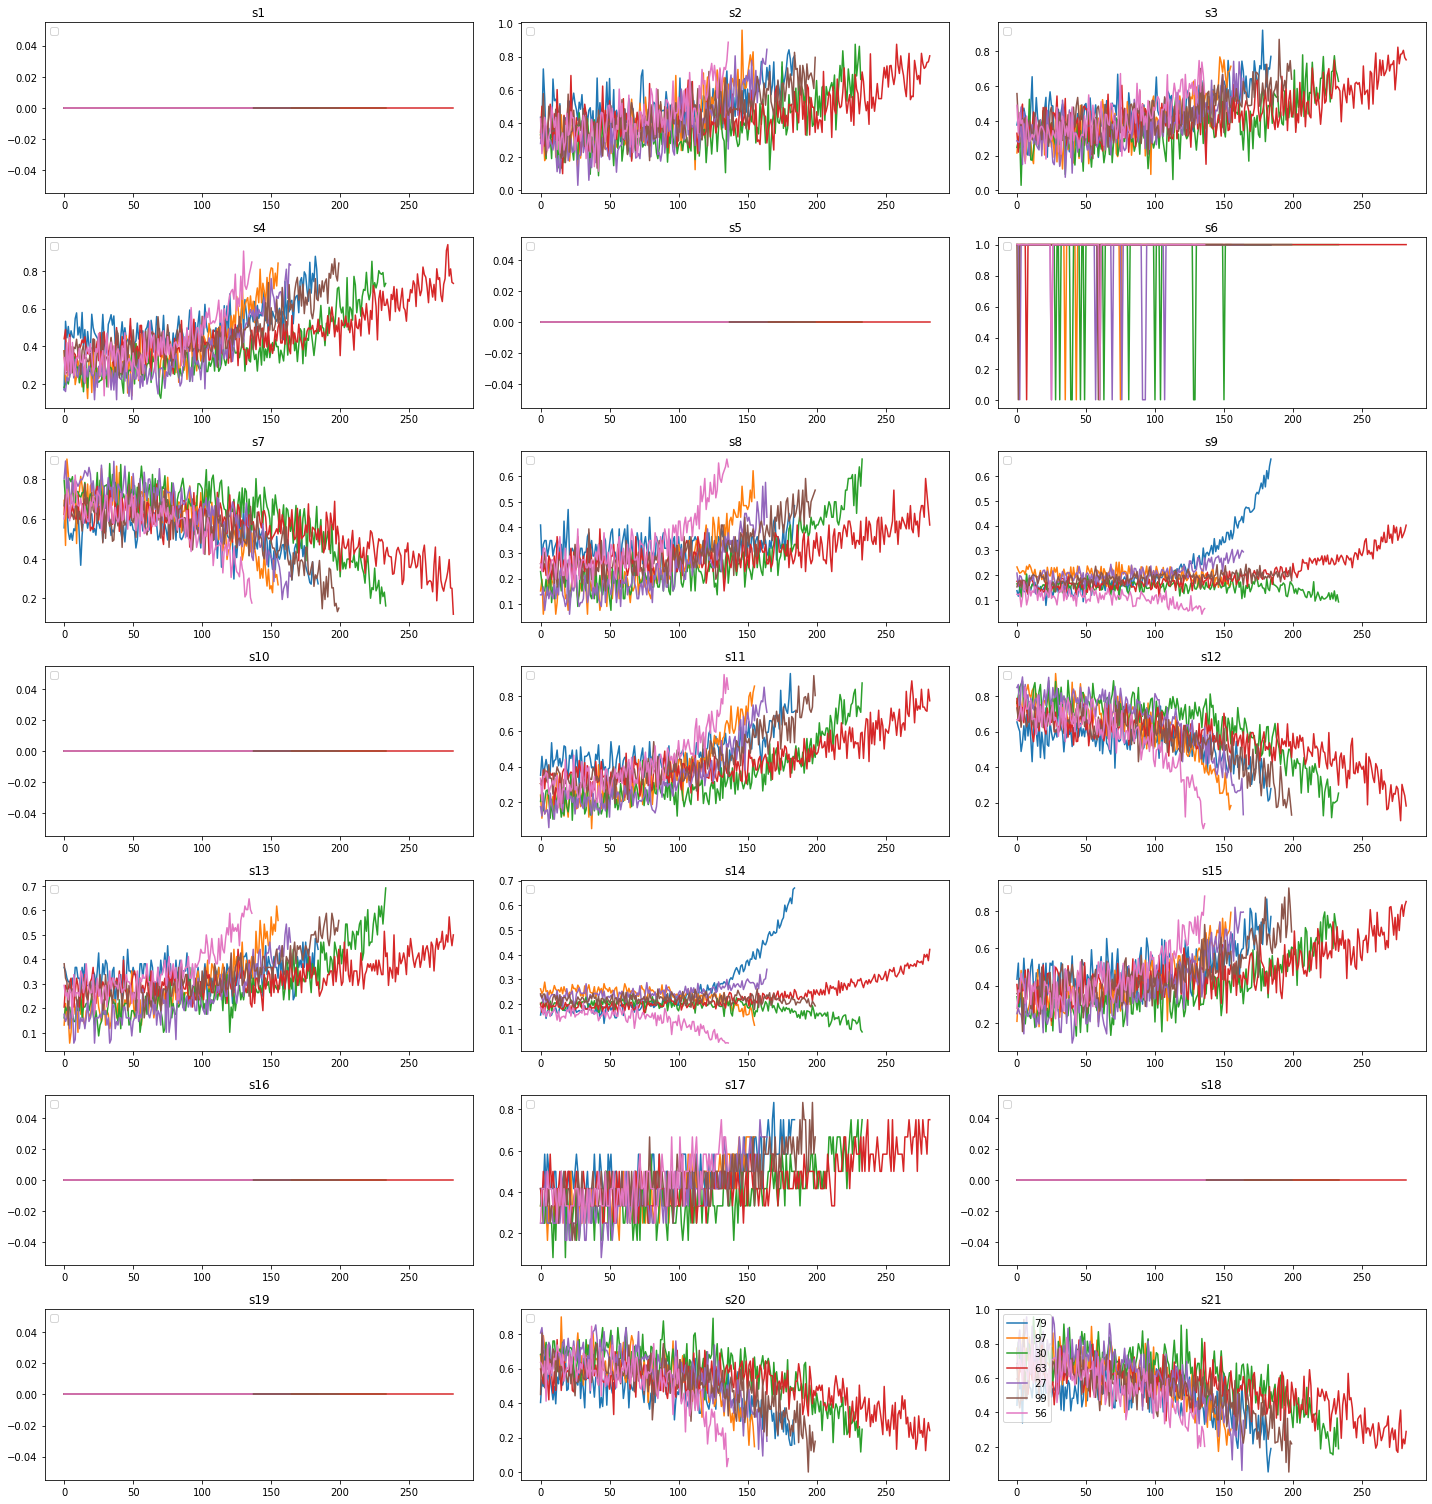

In [0]:
display_multiple( test_df, [79,97,30,63,27,99,56], sensor_cols)

In [0]:
def display_combined(df1,df2,engine_id, col_names):
    
    engine_data = []
    
    engine_data.append(df1[df1['id'] == engine_id])
    engine_data.append(df2[df2['id'] == engine_id])
        
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = n // nrows
    
    fig = plt.figure(figsize=(20, n))
        
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        for i in range(len(engine_data)):
            e = engine_data[i]
            x = np.arange(e.shape[0])
            y = e[m].values
            ax.plot(x, y)
    
    plt.tight_layout()
    plt.show()

In [0]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [17]:

label_array_test_last = test_df.groupby('id')['RUL','id'].nth(-1)
#label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)

(100, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


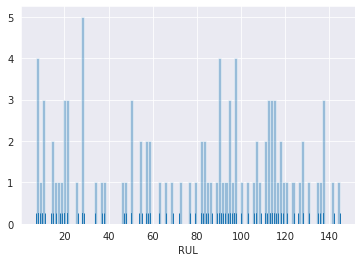

In [45]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(label_array_test_last['RUL'], kde=False, rug=True, bins=100);

In [25]:
label_array_test_last[label_array_test_last['RUL'] > 140] #63 82 84 

,RUL,id
id,,
25,145,25
39,142,39


In [0]:
label_array_test_last[label_array_test_last['id']== 79] #63 82 84 

,RUL,id
id,,
79,63,79


In [0]:
good:
RUL: 72, 66,117
_ID: 63, 27,99
bad:
RUL: 63,82,115
_ID: 79,97,30

In [0]:
srul = label_array_test_last['RUL' ==]

Text(0, 0.5, 'Count')

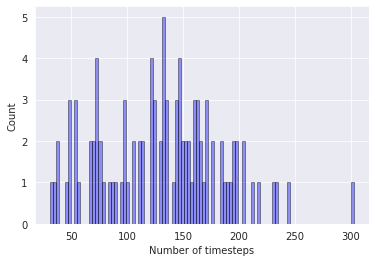

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(label_array_test_last['RUL'], color = 'blue', edgecolor = 'black')

# seaborn histogram
sns.distplot(windowSize, hist=True, kde=False, 
              color = 'blue',bins=100,
            hist_kws={'edgecolor':'black'})
# Add labels
plt.xlabel('Number of timesteps')
plt.ylabel('Count')

In [0]:
windowSizeTrain =  train_df.groupby('id')['id'].count()


In [71]:
windowSizeTrain

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: id, Length: 100, dtype: int64

Text(0, 0.5, 'Count')

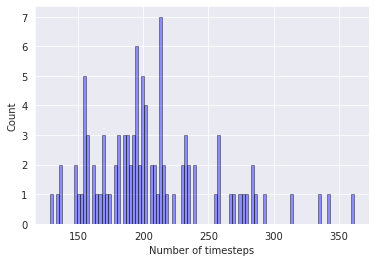

In [76]:

sns.distplot(windowSizeTrain, hist=True, kde=False, 
              color = 'blue',bins=100,
            hist_kws={'edgecolor':'black'})
# Add labels
plt.xlabel('Number of timesteps')
plt.ylabel('Count')